# <u> **Product Recommendation Models for Amazon Products** </u>

A product recommendation model is a machine learning or data-driven system designed to provide recommendations to users based on their preferences, behaviors, or past interactions with products or content. These models are widely used in various domains, including e-commerce, online streaming, news websites, and more, to help users discover relevant items or content.

Product recommendation Models are important to businesses for several reasons:

`Increased Sales and Revenue`
> Recommendation models can significantly boost sales and revenue by suggesting relevant products to customers. When customers see items they are more likely to purchase, it can lead to higher conversion rates and larger order values.

`Cross-Selling and Upselling`
> Recommendation models can suggest complementary or higher-priced items to customers, increasing the chances of cross-selling and upselling. For example, suggesting accessories for a purchased product or a premium version of a product can drive additional revenue.

`Enhanced Customer Experience`
> Recommending products that align with a customer's interests and preferences can greatly improve the overall shopping experience. It helps customers find what they are looking for quickly and easily, which can lead to higher customer satisfaction and loyalty.

`Inventory Management`
> By promoting products that may not be selling well or need to be cleared from the inventory, businesses can better manage their stock and reduce the risk of overstocking or understocking.

`Reduced Decision Fatigue`
> In today's world of information overload, customers are often overwhelmed by choices. Recommendation models simplify decision-making by narrowing down options, reducing the cognitive load on customers.

`Marketing Efficiency`
> Recommendation models can optimize marketing efforts by targeting customers with products they are more likely to be interested in. This increases the efficiency and effectiveness of marketing campaigns.

<p>&nbsp;</p>

*In this project I will firstly do some Exploratory Data Analysis (EDA) and Data Cleaning, then I will create recommendation models on more than 7 million user-item Amazon data entries.*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#Surprise library for collebrative filtering stuff
!pip install surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Recommendation_engine'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

df = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'ratings_Electronics.csv'), names=['userId', 'productId','rating','timestamp'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['ratings_Electronics.csv', 'Amazon_product_recommendation_model.ipynb']


##Dataset

The Amazon dataset contains the following attributes:

*   `UserId:` Every user identified with a unique id
*   `ProductId:` Every product identified with a unique id
*   `Rating:` The rating of the corresponding product by the corresponding user
*   `Timestamp:` Time of the rating. We will not use this column to solve the current


##1. Exploratory Data Analysis

In [ ]:
df.shape

(7824482, 4)

In [ ]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
df.drop('timestamp',axis=1,inplace=True)

In [ ]:
#handling missing values
df.isnull().sum()

userId       0
productId    0
rating       0
dtype: int64

In [ ]:
#handling duplicate records
df[df.duplicated()].shape[0]

0

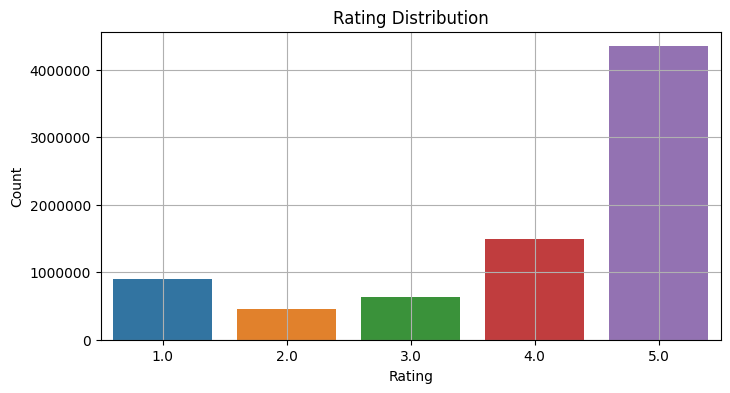

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='rating',data=df)
# plt.yscale("log")
plt.ticklabel_format(style='plain', axis='y')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid()
plt.show()

In [ ]:
print(f"Total rating : {df.shape[0]}")
print(f"Total unique users : {df['userId'].unique().shape[0]}")
print(f"Total unique products : {df['productId'].unique().shape[0]}")

Total rating : 7824482
Total unique users : 4201696
Total unique products : 476002


In [ ]:
num_of_rated_products_per_user = df.groupby(by='userId')['rating'].count().sort_values(ascending=False)
print(f"Number of users that have rated more than 50 products: {sum(num_of_rated_products_per_user >= 50)} ")

Number of users that have rated more than 50 products: 1540 


##Types of Recommendation Systems Used

1.   Popularity Based Recommendation
2.   Collaberative filtering



### **Popularity Based Recommendation**

Popularity-based recommendation systems are a type of recommendation system that suggest items to users based on their popularity or overall popularity among all users. These systems do not take into account the individual preferences or behavior of users but instead rely on the assumption that popular items are more likely to be of interest to users in general

####<u> Benefits </u>

***Simplicity:*** They are easy to implement and computationally efficient since they don't require complex algorithms or personalised user data.

***Initialization:*** They can be a good starting point for new users or when there is limited data available about user preferences.

####<u> Drawbacks</u>

***Lack of Personalisation:*** Popularity-based recommendations do not take into account the unique preferences of individual users. What's popular for one user might not be relevant to another.

***Cold Start Problem:*** They struggle with the "cold start" problem, where new items or users have little to no interaction data, making it difficult to make recommendations.

***Bubbling Effect:*** They can reinforce popularity biases, where already popular items become even more popular, while lesser-known items remain hidden.




In [ ]:
data = df.groupby('productId').filter(lambda x:x['rating'].count()>=50)

In [ ]:
data.head()

,userId,productId,rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [ ]:
num_of_ratings_per_product = data.groupby('productId')['rating'].count().sort_values(ascending=False)

In [ ]:
num_of_ratings_per_product.head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: rating, dtype: int64

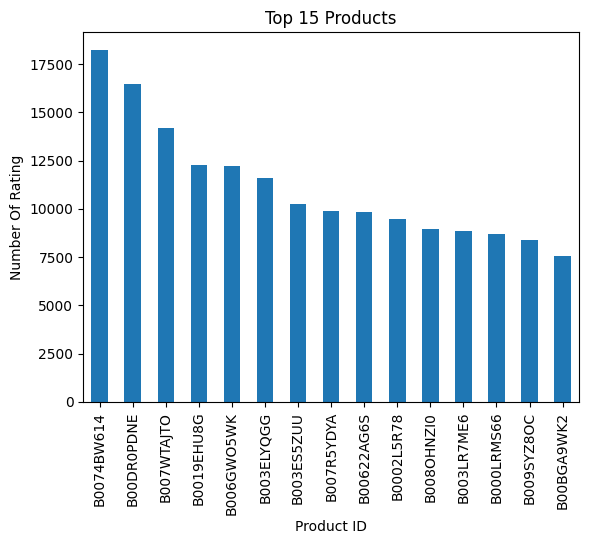

In [ ]:
#top 15 product
num_of_ratings_per_product.head(15).plot(kind='bar')
plt.xlabel('Product ID')
plt.ylabel('Number Of Rating')
plt.title('Top 15 Products')
plt.show()

In [ ]:
#average product rating
mean_product_rating_count = pd.DataFrame(data.groupby('productId')['rating'].mean())

In [ ]:
mean_product_rating_count.head()

,rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


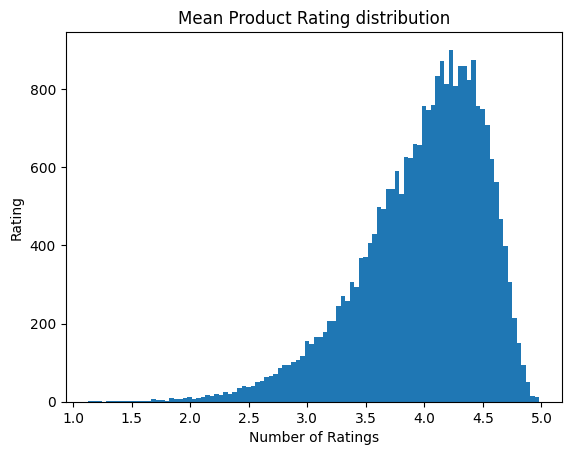

In [ ]:
#plot the distribution of mean product rating
plt.hist(mean_product_rating_count['rating'], bins=100)
plt.title('Mean Product Rating distribution')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

In [ ]:
#check the skewness of the mean rating data
mean_product_rating_count['rating'].skew()

-0.9512537061128555

In [ ]:
mean_product_rating_count['rating_counts'] = pd.DataFrame(data.groupby('productId')['rating'].count())

In [ ]:
#highest mean rating product
max_rating = mean_product_rating_count['rating_counts'].max()
min_rating = mean_product_rating_count['rating_counts'].min()
mean_product_rating_count[mean_product_rating_count['rating_counts'] == max_rating]

,rating,rating_counts
productId,,
B0074BW614,4.491504,18244


In [ ]:
#min mean rating product
print(f"min average rating product : {min_rating}")
print(f"total products above minimum average rating : {mean_product_rating_count[mean_product_rating_count['rating_counts'] >= min_rating].shape[0]}")

min average rating product : 50
total products above minimum average rating : 26226


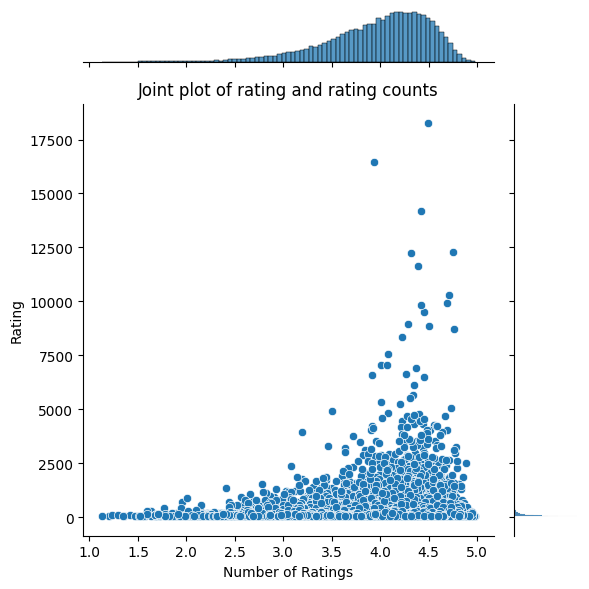

In [ ]:
#joint plot of rating and rating counts
sns.jointplot(x='rating', y='rating_counts', data=mean_product_rating_count)
plt.title('Joint plot of rating and rating counts')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

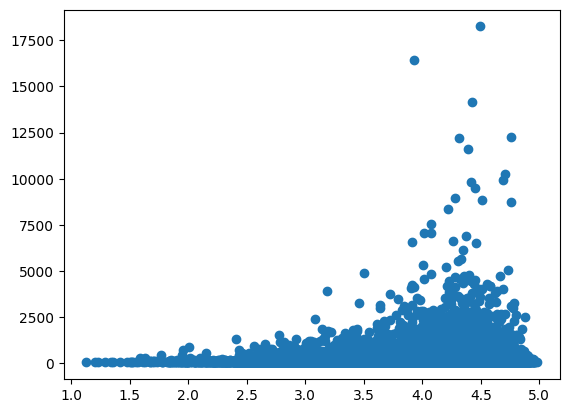

In [ ]:
plt.scatter(x=mean_product_rating_count['rating'], y=mean_product_rating_count['rating_counts'])
plt.show()

In [ ]:
print(f"Correlation between Rating and Rating Counts is : {mean_product_rating_count['rating'].corr(mean_product_rating_count['rating_counts'])}")

Correlation between Rating and Rating Counts is : 0.07358807628426929


### **Collaberative filtering**

Collaborative filtering is a popular technique used in recommendation systems to provide personalised recommendations to users based on their historical behavior and preferences, as well as the behavior and preferences of similar users. It relies on the idea that users who have interacted with items in similar ways in the past are likely to have similar tastes and interests.

####<u> Benefits </u>

***Personalisation:*** They provide personalised recommendations based on user behavior and preferences.

***Apparency:*** They can help users discover new items or content based on the behavior of similar users

####<u> Drawbacks </u>

***Cold Start Problem:*** They struggle to make recommendations for new users or items with little to no interaction data.

***Scalability:*** For systems with a large number of users and items, the computation of similarity scores can become computationally expensive.

In [ ]:
sample_percent = 20
sample_size = df.shape[0] // round(100/sample_percent)
randomised_sample = df.sample(n=sample_size, ignore_index=True)
random_sample_grouped = randomised_sample.groupby('productId').filter(lambda x:x['rating'].count()>=50)

In [ ]:
del df

#####<ins>Memory-based Collaborative filtering (Item-Based)</ins>

In item-based collaborative filtering, recommendations are made by finding items that are similar to the ones the target user has already liked or interacted with.

A user-item matrix is created and we calculate the item similarity based on how users have interacted with items. Items with similar patterns of user interaction have higher similarity scores. To make recommendations for a target user, the system identifies items the user has already interacted with and suggests similar items that the user has not yet seen or interacted with.


In [ ]:
#Reading and Splitting the dataset into 80:20 ratio using train_test_split
reader = Reader(rating_scale=(1, 5))
surprise_loaded__data = Dataset.load_from_df(random_sample_grouped, reader)

In [ ]:
trainset, testset = train_test_split(surprise_loaded__data, test_size=0.3, random_state=42)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
#Prediction using testset
test_pred = algo.test(testset)

In [ ]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3123


1.3123435344759096

#####<ins>Model-based Collaborative filtering (Item-Based)</ins>

Model-based collaborative filtering takes a different approach by building predictive models to make recommendations. With this approach, the models are trained on user-item interaction data such as product ratings provided by a user to make predictions on other unseen products. The products a user is most likely to rate highly are then recommended to them.

Model-based collaborative filtering tends to be more scalable and effective for handling sparse data compared to memory-based methods (If sparcity measures are taken such as SVD). It also handles the "cold start" problem better because it can make recommendations even when there is little interaction data for new users or items. However, it requires more complex modeling and training processes.

In [ ]:
data2 = random_sample_grouped.sample(20000)
ratings_matrix = data2.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400532655,140053271X,B00000DM9W,B00000J061,B00000J1V5,B00000JI4F,B00000K2YR,B00001P4XA,B00001P4XH,...,B00HTPHK5W,B00HVLUR86,B00I2ZBD1U,B00I94IPTW,B00IF70QCW,B00IGISO9C,B00INNP5VU,B00IO1V33U,B00ISGCAJM,B00J46VVKE
userId,,,,,,,,,,,,,,,,,,,,,
A00010809P09NUU6ZP6H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0047322388NOTO4N8SKD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0188986ZFR9812QXBZL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A020057121BB5RIXSHWDG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030857430C24W5CFIR2V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.shape

(19872, 4377)

In [ ]:
x_ratings_matrix=ratings_matrix.T
x_ratings_matrix.head()

userId,A00010809P09NUU6ZP6H,A0047322388NOTO4N8SKD,A0188986ZFR9812QXBZL,A020057121BB5RIXSHWDG,A030857430C24W5CFIR2V,A0343389GGYY2GNMHHF,A0353867B684O2TSD3C0,A03605631ICATFHK20PJ1,A03634112W6DUJJO0FVE5,A0424894FXU3P9YFW6YF,...,AZY60RUVG1EFK,AZY72EKBIDTJU,AZYJE40XW6MFG,AZYRLYL6T7JEU,AZYTGWZKQ8Q8O,AZYXOC7ERAJS0,AZZ7E52SB0L34,AZZJEY1OABLFA,AZZLPESEJM2AE,AZZTC2OYVNE2Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140053271X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000DM9W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000J061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(x_ratings_matrix)
decomposed_matrix.shape

(4377, 10)

In [ ]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(4377, 4377)

In [ ]:
#For item based collaborative filtering
i="B00005ATMI"
product_names=list(x_ratings_matrix.index)
product_id=product_names.index(i)
print(product_id)

40


In [ ]:
#Correlation for all items with  item i, purchased by this customer,
# based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_id]
correlation_product_ID.shape

(4377,)

In [ ]:
correlation_matrix[correlation_product_ID>0.75].shape

(230, 4377)

In [ ]:
#Recommending top 10 highly correlated products in sequence
recommendations = list(x_ratings_matrix.index[correlation_product_ID > 0.75])
recommendations[:10]

['B00000JI4F',
 'B00001P4XA',
 'B00001P4ZH',
 'B00005ARK3',
 'B00005ATMI',
 'B00005T39Y',
 'B000063TJY',
 'B00006I5WJ',
 'B00008VWOJ',
 'B0000A2QBP']